In [32]:
import sys
sys.path.append('/home/svdcvt/miniconda3/lib/python3.8/site-packages')

In [33]:
import tinkhorn
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [17]:
# # two gaussians
# n, m, d = 100, 100, 5
# bin_size = 8
# X = np.random.normal(loc=-1, scale=0.5, size=(n, d))
# Y = np.random.normal(loc=3, scale=0.2, size=(m, d))
# percentile = [99, 99.9]
# percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
# percentile_b = [(percentile_b * 10) % 100, percentile_b]

In [95]:
beta = 0.01 # regularization coefficient 

# # pointcloud: X - center cloud, Y - 3 clouds near X
# n, m, d = 50, 50, 2
# bin_size = 16
# percentile = [90, 99]
# percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
# percentile_b = [(percentile_b * 10) % 100, percentile_b]
# gauss = lambda q, a, c: a * np.random.randn(q, d) + (np.tile(c, (q, 1)))
# X = np.random.randn(n, d) * .3
# Y = np.vstack([gauss(int(m / 2), .5, [0, 1.6]), 
#                gauss(int(m / 4), .3, [-1, -1]),
#                gauss(int(m / 4), .3, [1, -1])])

# pointcloud: X - center square cloud, Y - circle cloud around X
n, m, d = 50, 50, 2
bin_size = 16
percentile = [99, 99.9]
percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
percentile_b = [(percentile_b * 10) % 100, percentile_b]
X = np.random.rand(n, d) - .5
theta = 2 * np.pi * np.random.rand(m, 1)
r = .8 + .2 * np.random.rand(m, 1)
Y = np.hstack((np.cos(theta) * r, np.sin(theta) * r))


In [69]:
beta = 0.01 # regularization coefficient 

# # pointcloud: X - center cloud, Y - 3 clouds near X
n, m, d = 500, 500, 3
bin_size = 8
percentile = [90, 99]
percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
percentile_b = [(percentile_b * 10) % 100, percentile_b]
gauss = lambda q, a, c: a * np.random.randn(q, d) + (np.tile(c, (q, 1)))
X = np.random.randn(n, d) * .3
Y = np.vstack([gauss(int(m / 4), .3, [0,   1.4, -2]),
               gauss(int(m / 4), .3, [-0.99, -0.99, -2]),
               gauss(int(m / 4), .3, [1,  -1, -2]),
               gauss(int(m / 4), .3, [0,   0,  6 ** 0.5])])

# pointcloud: X - center square cloud, Y - circle cloud around X
# n, m, d = 500, 500, 3
# bin_size = 8
# percentile = [99, 99.9]
# percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
# percentile_b = [(percentile_b * 10) % 100, percentile_b]
# X = np.random.rand(n, d) - .5
# theta = np.pi * np.random.rand(m, 1)
# phi = 2 * np.pi * np.random.rand(m, 1)
# r = 1.8 + .2 * np.random.rand(m, 1)
# Y = np.hstack((np.sin(theta) * np.cos(phi) * r, np.sin(theta) * np.sin(phi) * r, np.cos(theta) * r))


In [96]:
C_points = cdist(X, Y)

In [97]:
# normalize = lambda a: a/np.sum(a)
# a = normalize(np.random.rand(n, 1))
# b = normalize(np.random.rand(m, 1))
aX = np.full((n, 1), 1 / n)
bY = np.full((m, 1), 1 / m)

In [98]:
plotp = lambda x, col: plt.scatter(x[:, 0], x[:, 1], s=200, edgecolors="k", c=col, linewidths=2)

In [73]:
def plotp3d(X, Y):
    fig = plt.figure(figsize=(8,8), )
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('3d cloudpints')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(X[:,0], X[:,1], X[:,2], alpha=0.5)
    ax.scatter(Y[:,0], Y[:,1], Y[:,2], alpha=0.5)
    plt.show()

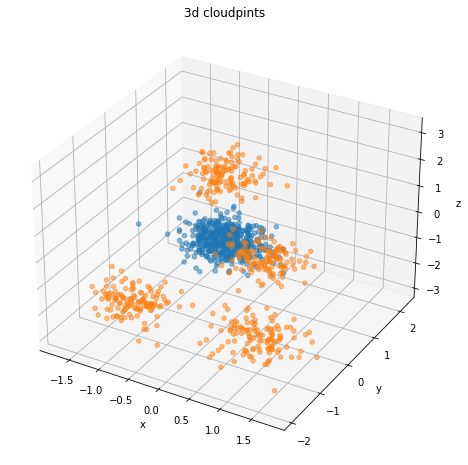

In [74]:
plotp3d(X, Y)

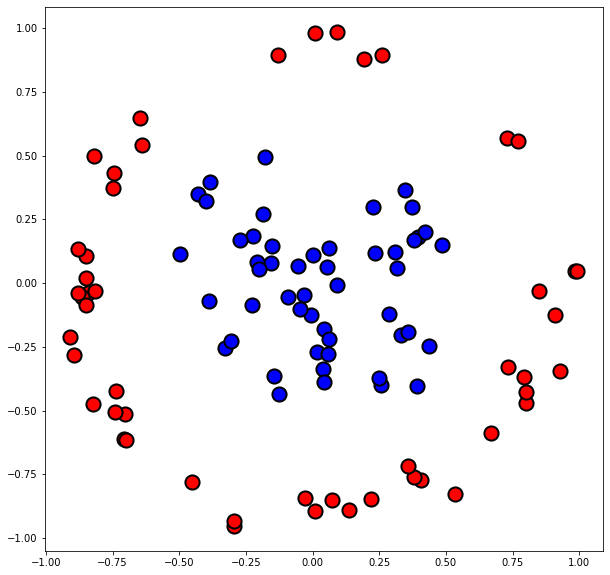

In [99]:
plt.figure(figsize = (10, 10))
# plt.axis("off")
plotp(X, 'b')
plotp(Y, 'r')
# plt.xlim(np.min(Y[:, 0]) - .1, np.max(Y[:, 0]) + .1)
# plt.ylim(np.min(Y[:, 1]) - .1, np.max(Y[:, 1]) + .1)
plt.show()

#iterations=65, early stopping: tol, err=6.822945324839705e-12


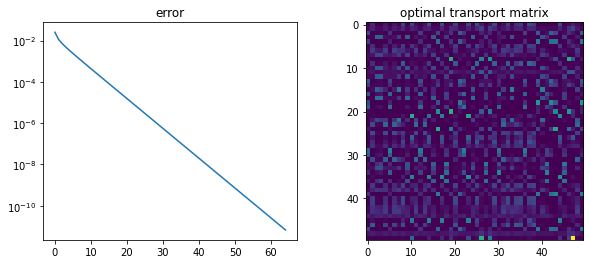

In [100]:
beta_ = 0.1
K, a, b = tinkhorn.sinkhorn(X, Y, beta=beta_, max_iter=1000, 
                            early_stopping=True, plot=True)

In [101]:
P = np.dot(np.dot(np.diag(a), K), np.diag(b))

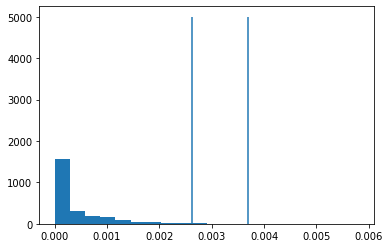

In [102]:
bounds = np.percentile(P.ravel(), percentile)
plt.hist(P.ravel(), bins=20)
plt.vlines(bounds, 0, 5000)
plt.show()

In [103]:
(P>0).sum(), (P > bounds[0]).sum(), (P > bounds[1]).sum(), np.prod(P.shape)

(2500, 25, 3, 2500)

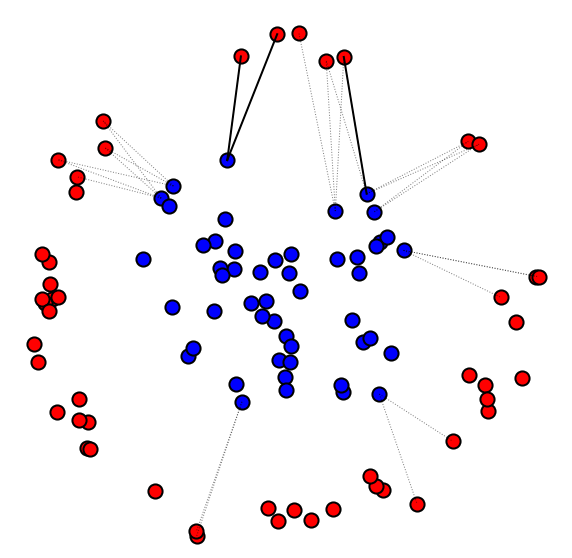

In [104]:
plt.figure(figsize = (10,10))
plotp(X, 'b')
plotp(Y, 'r')

A = P * (P > bounds[1])
i,j = np.where(A != 0)
plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], 'k', lw = 2)

A = P * (P > bounds[0])
i,j = np.where(A != 0)
plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], 'k:', alpha=0.5, lw = 1)

plt.axis("off")
plt.xlim(min(np.min(Y[:, 0]), np.min(X[:, 0])) - .1, max(np.max(X[:, 0]), np.max(Y[:, 0])) + .1)
plt.ylim(min(np.min(Y[:, 0]), np.min(X[:, 1])) - .1, max(np.max(X[:, 0]), np.max(Y[:, 1])) + .1)

plt.show()

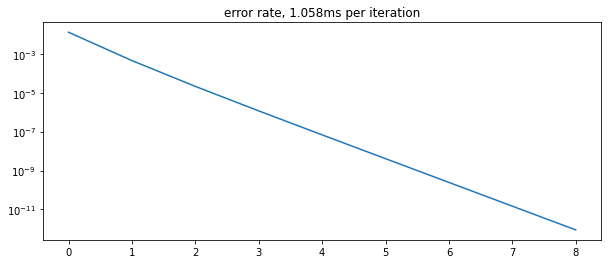

#iterations=9, early stopping: eps, err=8.748494989061702e-13
Finished


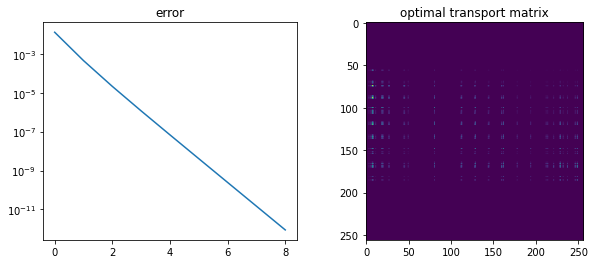

In [105]:
beta_ = 0.8
K, a, b, bins, x, y = tinkhorn.sinkhorn_toeplitz(X, Y, bin_size=bin_size, beta=beta_, max_iter=1000, 
                                           early_stopping=True, plot=True)

In [106]:
P = np.dot(np.dot(np.diag(a), K), np.diag(b))

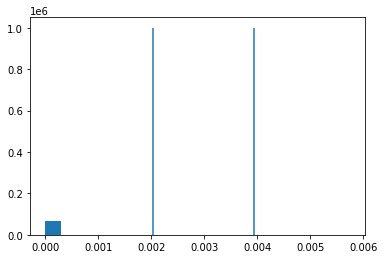

In [107]:
bounds = np.percentile(P.ravel(), [99.9, 99.99])
plt.hist(P.ravel(), bins=20)
plt.vlines(bounds, 0, 1000000)
plt.show()

In [108]:
(P>0).sum(), (P > bounds[0]).sum(), (P > bounds[1]).sum(), 256*256

(1190, 66, 7, 65536)

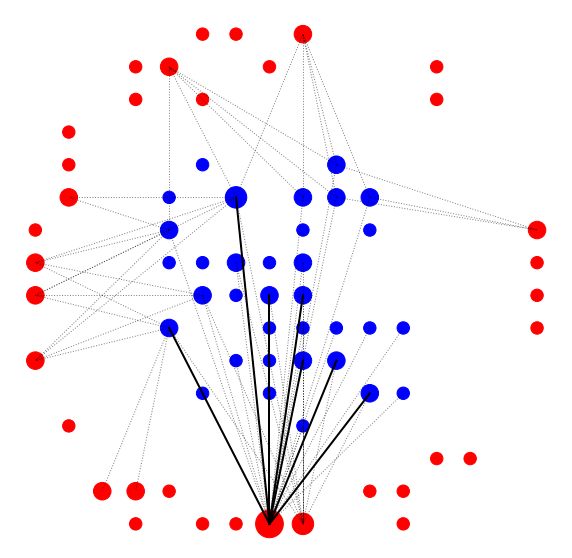

In [109]:
plt.figure(figsize = (10,10))
plt.scatter(bins[:,0], bins[:,1], s=x * len(x) * 30, c='b')
plt.scatter(bins[:,0], bins[:,1], s=y * len(y) * 30, c='r')

A = P * (P > bounds[1])
i, j = np.where(A != 0)
plt.plot([bins[i, 0], bins[j, 0]], [bins[i, 1], bins[j, 1]], 'k', lw = 2)

A = P * (P > bounds[0])
i, j = np.where(A != 0)
plt.plot([bins[i, 0], bins[j, 0]], [bins[i, 1], bins[j, 1]], 'k:', alpha=0.5, lw = 1)

plt.axis("off")
plt.xlim(np.min(bins[:, 0]) - .1, np.max(bins[:, 0]) + .1)
plt.ylim(np.min(bins[:, 1]) - .1, np.max(bins[:, 1]) + .1)

plt.show()

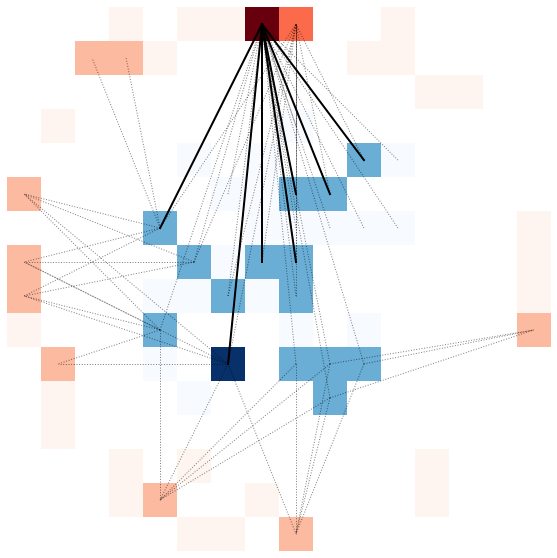

In [110]:
Xbins, Ybins = np.meshgrid(np.arange(bin_size), np.arange(bin_size))
Xbins = Xbins.ravel()
Ybins = Ybins.ravel()

plt.figure(figsize = (10,10))
plt.imshow(np.where(x > 0, x, np.nan).reshape(bin_size, bin_size), cmap='Blues')
plt.imshow(np.where(y > 0, y, np.nan).reshape(bin_size, bin_size), cmap='Reds')

A = P * (P > bounds[1])
i, j = np.where(A != 0)
plt.plot([Xbins[i], Xbins[j]], [Ybins[i], Ybins[j]], 'k', lw = 2)

A = P * (P > bounds[0])
i,j = np.where(A != 0)
plt.plot([Xbins[i], Xbins[j]], [Ybins[i], Ybins[j]], 'k:', alpha=0.5, lw = 1)

plt.axis("off")
plt.show()

### Barycentric mapping

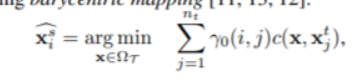

In [112]:
C_bins = cdist(bins, bins)

In [113]:
P.shape, C_bins.shape

((256, 256), (256, 256))

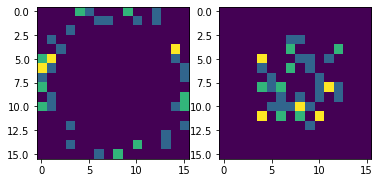

In [60]:
plt.subplot(121)
plt.imshow(np.exp(P.sum(0).reshape(bin_size, bin_size)))
plt.subplot(122)
plt.imshow(np.exp(P.sum(1).reshape(bin_size, bin_size)))

In [89]:
mapping = lambda gamma, c_t: np.argmin((gamma[:, None, :] * c_t).sum(-1), 1)

In [114]:
P[:, None, :].shape, C_bins.shape

((256, 1, 256), (256, 256))

In [91]:
map_source = bins[mapping(P, C_bins)]

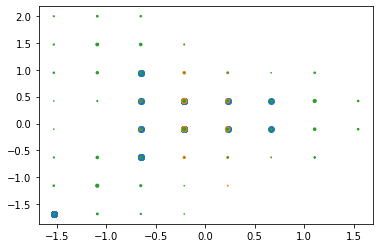

In [92]:
plt.scatter(map_source[:, 0], map_source[:,1])
plt.scatter(bins[:,0], bins[:,1], s=x*200)
plt.scatter(bins[:,0], bins[:,1], s=y*200)
plt.show()

In [93]:
B = lambda g, x: np.linalg.inv(np.diag(g.sum(0))).dot(g.T).T.dot(x)

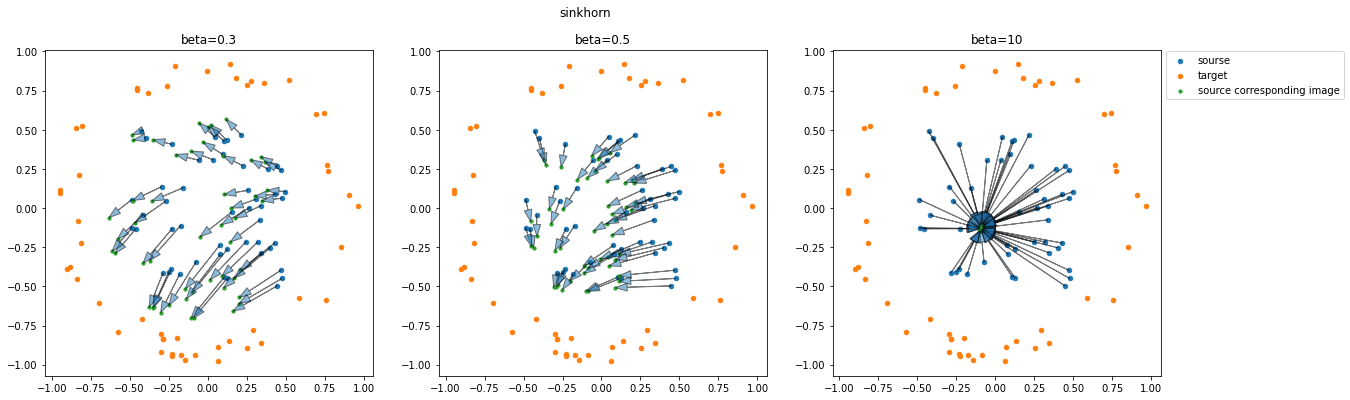

In [66]:
plt.figure(figsize = (20,6))
plt.suptitle('sinkhorn')
betas_ = [0.3, 0.5, 10]
for i, beta_ in enumerate(betas_):
    K, a, b = tinkhorn.sinkhorn(X, Y, beta=beta_, max_iter=1000, 
                                early_stopping=False, plot=False, verbose=False)
    P = np.dot(np.dot(np.diag(a), K), np.diag(b))
    hat_X = B(P, Y)
    plt.subplot(1, 3, i + 1)
    plt.title(f'beta={beta_}')
    plt.scatter(X[:,0], X[:,1], s=20, label='sourse')
    plt.scatter(Y[:,0], Y[:,1], s=20, label='target')
    plt.scatter(hat_X[:,0], hat_X[:,1], s=10, marker='o', label='source corresponding image')
    for j in range(len(X)):
        plt.arrow(X[j, 0], X[j, 1], hat_X[j, 0] - X[j, 0], hat_X[j, 1] - X[j, 1], 
                  head_width=0.05, alpha=0.5, length_includes_head=True)
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

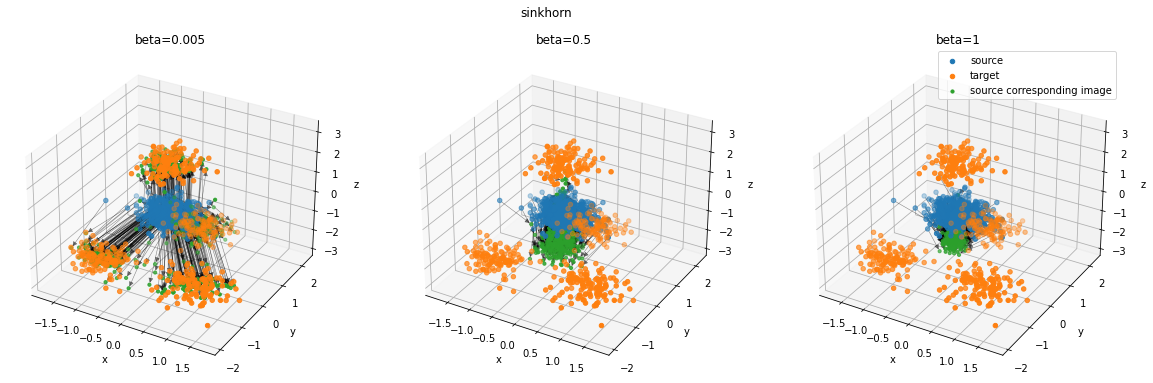

In [94]:
from utils import Arrow3D

fig = plt.figure(figsize = (20,6))
fig.suptitle('sinkhorn')
betas_ = [0.005, 0.5, 1]
for i, beta_ in enumerate(betas_):
    K, a, b = tinkhorn.sinkhorn(X, Y, beta=beta_, max_iter=1000, 
                                early_stopping=False, plot=False, verbose=False)
    P = np.dot(np.dot(np.diag(a), K), np.diag(b))
    hat_X = B(P, Y)
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.set_title(f'beta={beta_}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.scatter(X[:,0], X[:,1], X[:,2], s=20, label='source')
    ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=20, label='target')
    ax.scatter(hat_X[:,0], hat_X[:,1], hat_X[:,2], s=10, marker='o', label='source corresponding image')
    for j in range(len(X)):
        a = Arrow3D([X[j, 0],  hat_X[j, 0]], [X[j, 1],  hat_X[j, 1]], 
                [X[j, 2],  hat_X[j, 2]], mutation_scale=10, 
                lw=0.5, arrowstyle="-|>", color="k", alpha=0.5)
        ax.add_artist(a)
        
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

In [79]:
# ANIMATION
# fig.suptitle('toeplitz sinkhorn')
betas_ = np.linspace(0.005, 1, 50)
betas_ = np.logspace(-3, 1, 85, base=10)[:50] * 5
# betas_ = [0.005, 2]

for i, beta_ in enumerate(betas_):
    print(beta_, end=' . ')
    K, a, b = tinkhorn.sinkhorn(X, Y, beta=beta_, max_iter=1000, 
                                early_stopping=False, plot=False, verbose=False)
    P = np.dot(np.dot(np.diag(a), K), np.diag(b))
    hat_X = B(P, Y)
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.set_title(f'beta={beta_:1.4}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.scatter(X[:,0], X[:,1], X[:,2], s=20, label='source')
    ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=20, label='target')
    ax.scatter(hat_X[:,0], hat_X[:,1], hat_X[:,2], s=10, marker='o', label='source corresponding image')
    for j in range(len(X)):
        a = Arrow3D([X[j, 0],  hat_X[j, 0]], [X[j, 1],  hat_X[j, 1]], 
                [X[j, 2],  hat_X[j, 2]], mutation_scale=10, 
                lw=0.5, arrowstyle="-|>", color="k", alpha=0.5)
        ax.add_artist(a)
    fig.savefig(f'anim4/a_{str.zfill(str(i), 2)}.png', facecolor=(1,1,1))
    plt.close(fig)

0.005 . 0.00557941996253874 . 0.006225985423675166 . 0.006947477471865687 . 0.007752578899163126 . 0.008650978694229471 . 0.009653488644416248 . 0.010772173450159421 . 0.012020495917549858 . 0.013413478976398623 . 0.014967886473602452 . 0.01670242491756622 . 0.01863796860157469 . 0.020797810815359235 . 0.023207944168063887 . 0.025897373396156064 . 0.028898464420766566 . 0.032247333855188104 . 0.03598428365005761 . 0.04015428610695756 . 0.04480752509733025 . 0.05 . 0.0557941996253874 . 0.06225985423675162 . 0.06947477471865687 . 0.07752578899163123 . 0.08650978694229472 . 0.09653488644416247 . 0.10772173450159417 . 0.1202049591754986 . 0.13413478976398624 . 0.14967886473602446 . 0.16702424917566222 . 0.186379686015747 . 0.20797810815359236 . 0.23207944168063888 . 0.2589737339615605 . 0.2889846442076657 . 0.32247333855188104 . 0.3598428365005759 . 0.40154286106957565 . 0.44807525097330225 . 0.5 . 0.5579419962538741 . 0.622598542367516 . 0.6947477471865687 . 0.775257889916312 . 0.86509786

Starting iterative process
Finished
Starting iterative process
Finished
Starting iterative process
Finished


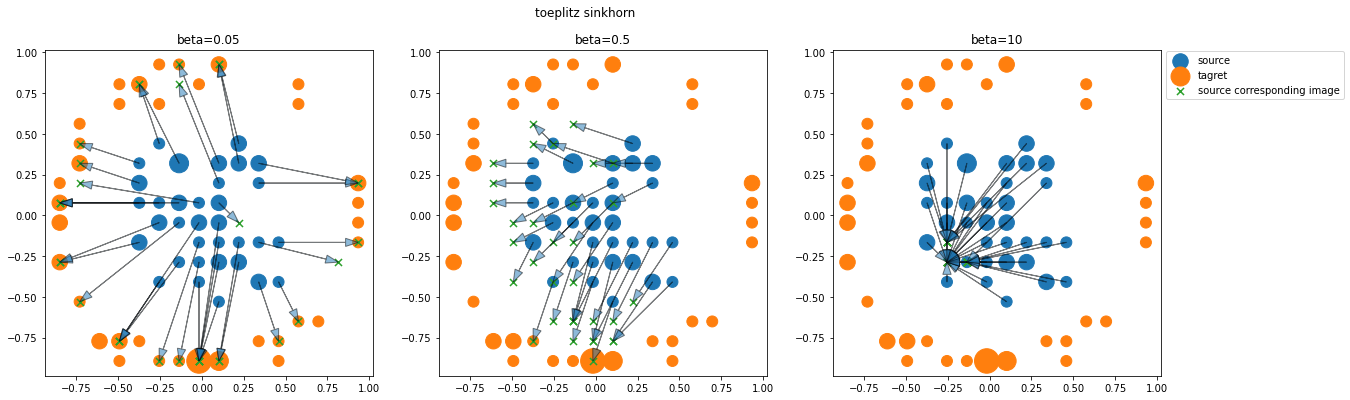

In [115]:
plt.figure(figsize = (20,6))
plt.suptitle('toeplitz sinkhorn')
betas_ = [0.05, 0.5, 10]

for i, beta_ in enumerate(betas_):
    K, a, b, bins, x, y = tinkhorn.sinkhorn_toeplitz(X, Y, bin_size=bin_size, beta=beta_, max_iter=1000, 
                                               early_stopping=False, plot=False, verbose=False)
    P = np.dot(np.dot(np.diag(a), K), np.diag(b))
    
    xbins, ybins = bins[x>0], bins[y>0]

    hat_xbins = bins[mapping(P, C_bins)][x>0]
    plt.subplot(1, 3, i + 1)
    plt.title(f'beta={beta_}')
    plt.scatter(xbins[:,0], xbins[:,1], s=x[x>0]*200*30, label='source')
    plt.scatter(ybins[:,0], ybins[:,1], s=y[y>0]*200*30, label='tagret')
    plt.scatter(hat_xbins[:,0], hat_xbins[:,1], marker='x', s=50, label='source corresponding image')
    for j in range(len(xbins)):
        plt.arrow(xbins[j, 0], xbins[j, 1], hat_xbins[j, 0] - xbins[j, 0], hat_xbins[j, 1] - xbins[j, 1], 
                  head_width=0.05, alpha=0.5, length_includes_head=True)
plt.legend(bbox_to_anchor=(1., 1.01))
plt.show()

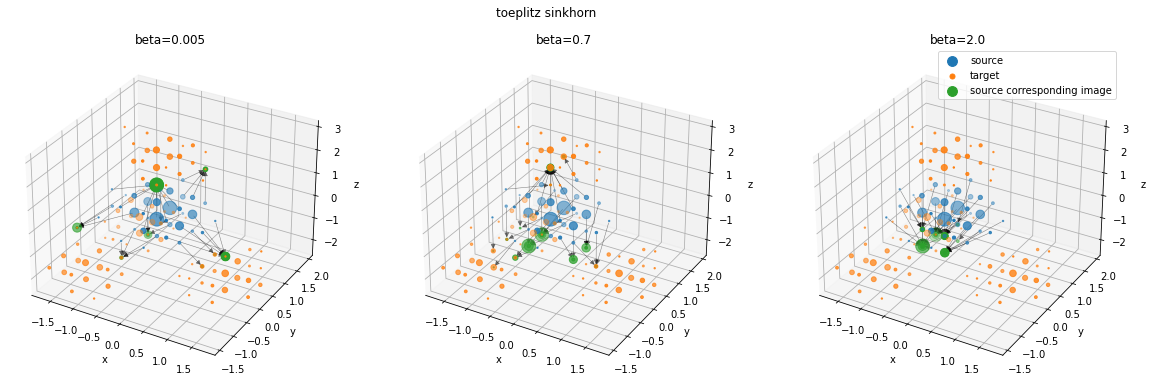

In [106]:
fig = plt.figure(figsize = (20,6))
fig.suptitle('toeplitz sinkhorn')
betas_ = [0.005, 0.7, 2.]
axes = []

for i, beta_ in enumerate(betas_):
    K, a, b, bins, x, y = tinkhorn.sinkhorn_toeplitz(X, Y, bin_size=bin_size, beta=beta_, max_iter=1000, 
                                               early_stopping=False, plot=False, verbose=False)
    P = np.dot(np.dot(np.diag(a), K), np.diag(b))
    
    xbins, ybins = bins[x>0], bins[y>0]

    hat_xbins = bins[mapping(P, C_bins)][x>0]
    
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    ax.set_title(f'beta={beta_:1.4}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.scatter(xbins[:,0], xbins[:,1], xbins[:,2], s=x[x>0]*1000, label='source')
    ax.scatter(ybins[:,0], ybins[:,1], ybins[:,2], s=y[y>0]*1000, label='target')
    ax.scatter(hat_xbins[:,0], hat_xbins[:,1], hat_xbins[:,2], s=x[x>0]*1000, marker='o', label='source corresponding image')
    for j in range(len(xbins)):
        arrow = Arrow3D([xbins[j, 0],  hat_xbins[j, 0]], [xbins[j, 1],  hat_xbins[j, 1]], 
                [xbins[j, 2],  hat_xbins[j, 2]], mutation_scale=10, 
                lw=0.5, arrowstyle="-|>", color="k", alpha=0.5)
        ax.add_artist(arrow)
ax.legend(bbox_to_anchor=(1., 1.01))
plt.show()

In [109]:
np.logspace(-3, 1, 70, base=10)[:50]*5

array([0.005     , 0.00571401, 0.00652998, 0.00746248, 0.00852813,
       0.00974597, 0.01113771, 0.0127282 , 0.01454582, 0.01662299,
       0.01899679, 0.02170957, 0.02480974, 0.02835262, 0.03240143,
       0.03702842, 0.04231616, 0.04835899, 0.05526476, 0.06315668,
       0.07217558, 0.0824824 , 0.09426106, 0.10772173, 0.12310462,
       0.14068421, 0.16077421, 0.1837331 , 0.20997056, 0.23995479,
       0.27422083, 0.31338013, 0.35813146, 0.40927337, 0.46771844,
       0.5345096 , 0.61083867, 0.6980677 , 0.7977532 , 0.911674  ,
       1.04186293, 1.1906431 , 1.36066938, 1.55497577, 1.77702952,
       2.03079299, 2.32079442, 2.65220864, 3.0309495 , 3.46377533])

In [110]:
# ANIMATION
# fig.suptitle('toeplitz sinkhorn')
betas_ = np.linspace(0.005, 1, 50)
betas_ = np.logspace(-3, 1, 70, base=10)[:50]*5
# betas_ = [0.005, 2]

for i, beta_ in enumerate(betas_):
    print(beta_, end=' . ')
    K, a, b, bins, x, y = tinkhorn.sinkhorn_toeplitz(X, Y, bin_size=bin_size, beta=beta_, max_iter=1000, 
                                               early_stopping=False, plot=False, verbose=False)
    P = np.dot(np.dot(np.diag(a), K), np.diag(b))
    
    xbins, ybins = bins[x>0], bins[y>0]

    hat_xbins = bins[mapping(P, C_bins)][x>0]
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.set_title(f'beta={beta_:1.4}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.scatter(xbins[:,0], xbins[:,1], xbins[:,2], s=x[x>0]*1000, label='source')
    ax.scatter(ybins[:,0], ybins[:,1], ybins[:,2], s=y[y>0]*1000, label='target')
    ax.scatter(hat_xbins[:,0], hat_xbins[:,1], hat_xbins[:,2], s=x[x>0]*1000, marker='o', label='source corresponding image')
    for j in range(len(xbins)):
        arrow = Arrow3D([xbins[j, 0],  hat_xbins[j, 0]], [xbins[j, 1],  hat_xbins[j, 1]], 
                [xbins[j, 2],  hat_xbins[j, 2]], mutation_scale=10, 
                lw=0.5, arrowstyle="-|>", color="k", alpha=0.5)
        ax.add_artist(arrow)
    fig.savefig(f'anim2/a_{str.zfill(str(i), 2)}.png', facecolor=(1,1,1))
    plt.close(fig)

0.005 . 0.00571401029905016 . 0.006529982739530267 . 0.007462477725259146 . 0.008528134915712643 . 0.009745970148014262 . 0.011137714759997782 . 0.012728203369302075 . 0.014545817028119402 . 0.01662298966135471 . 0.018996786825197027 . 0.02170956711360726 . 0.024809738015014515 . 0.028352619706905842 . 0.03240143220206254 . 0.037028423461312174 . 0.04231615860310571 . 0.048358993214877216 . 0.05526475705630107 . 0.06315667819884191 . 0.07217558193639591 . 0.08248240370490102 . 0.09426106085204358 . 0.10772173450159417 . 0.12310462007473127 . 0.1406842133935344 . 0.1607742088488853 . 0.1837330970368345 . 0.20997056174897108 . 0.23995479046619364 . 0.2742208288060509 . 0.3133801280023693 . 0.35813145578463934 . 0.40927336535345143 . 0.4677184449513084 . 0.5345096023015006 . 0.6108386744983959 . 0.6980676954283972 . 0.7977532002224146 . 0.9116740004342203 . 1.04186292557148 . 1.1906430973827935 . 1.3606693841876543 . 1.5549757749700994 . 1.777029518590532 . 2.0307929941884897 . 2.32079441

In [47]:
import sys
import mkl_fft
n = np.random.rand(4096)
sys.getsizeof(mkl_fft.fftn(n).astype('complex256')), sys.getsizeof(mkl_fft.fftn(n).astype('complex128'))

(131168, 65632)

In [18]:
mkl_fft.ifftn(mkl_fft.fftn(n).astype('complex256').astype('complex128'))

array([0.06192276-6.85343332e-18j, 0.24458161+2.51808397e-17j,
       0.7224378 +7.02605817e-17j, ..., 0.59639367+5.55825401e-17j,
       0.47539725+1.05744031e-17j, 0.5083316 -7.62860475e-17j])

embd dtype: float64
circ dtype: complex128
#iterations=137, early stopping: tol, err=2.016010044248849e-10


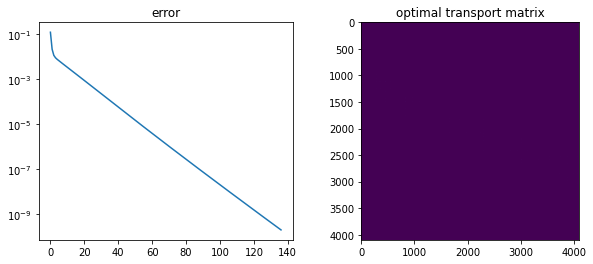

CPU times: user 3.2 s, sys: 1.06 s, total: 4.27 s
Wall time: 2.9 s


In [17]:
bbeta = 0.05
%time K_full, a, b, bins, p, q = tinkhorn.sinkhorn_toeplitz(X, Y, 64, beta=bbeta)

#iterations=191, early stopping: tol, err=1.1770905744566252e-09


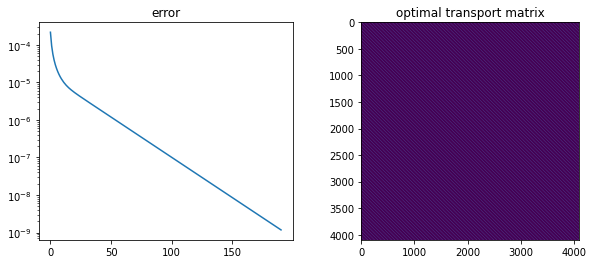

CPU times: user 42 s, sys: 5.09 s, total: 47.1 s
Wall time: 8.93 s


In [18]:
%time K, a, b = tinkhorn.sinkhorn(bins[:,0].reshape(-1,1), bins[:,0].reshape(-1,1), beta=bbeta)

In [140]:
def KL(f, s):
    return np.sum((f + 1e-12) * np.log((f + 1e-12) / (s + 1e-12)) - f + s)

def dot(a, b):
    return a.reshape(1, -1) * b.reshape(-1, 1)

def L(C, P):
    return np.sum(C * P)

def gamma(a, K, b):
    return np.diag(a) @ K @ np.diag(b)
    
# def C(K, beta):
#     return - np.log(K) * beta

C = -np.log(K_full) * bbeta
L(c, g), KL(g, dot(p, q)), L(C, g) + bbeta * KL(g, dot(p, q))

(0.5515746703958234, 18.772490524605534, 1.4901991966261001)

embd dtype: float64
circ dtype: complex128
#iterations=139, early stopping: tol, err=1.9469349260721824e-10


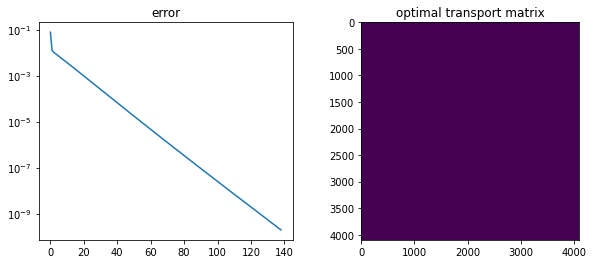

In [34]:
K_full, a, b, bins, p, q = tinkhorn.sinkhorn_toeplitz(Y, X, 64, beta=bbeta)

In [55]:
g2 = np.diag(a) @ K_full @ np.diag(b)

In [58]:
(g - g2.T).max()

1.592990543043877e-07

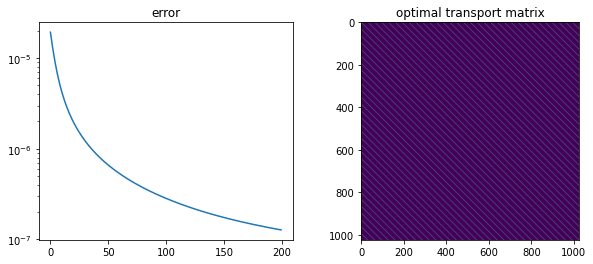

In [33]:
K, a, b = tinkhorn.sinkhorn(bins[:,0].reshape(-1,1), bins[:,0].reshape(-1,1), beta=0.02)

In [136]:
g_van = np.diag(a) @ K @ np.diag(b)

In [134]:
np.sum(C_points * g_van), KL(g_van, aX * bY.T)

(0.5251285340708414, 3.2323790915352215)

In [137]:
np.sum(C_points * g_van), KL(g_van, aX * bY.T)

(0.9433522287492271, 2.4506940836927136e-06)

#iterations=12, early stopping: eps, err=3.4973325279808703e-13


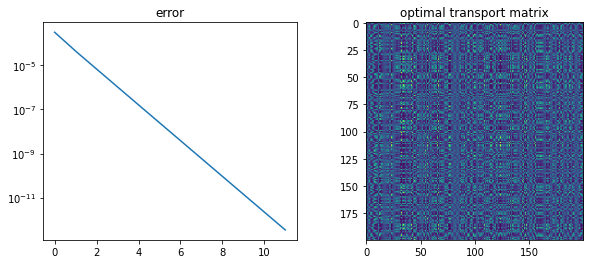

In [96]:
K, a, b = tinkhorn.sinkhorn(Y, X, beta=bbeta)

In [97]:
g_van2 = np.diag(a) @ K @ np.diag(b)

In [51]:
(g_van - g_van2.T).max()

2.4998408237105613e-11

In [98]:
np.sum(C_points * g_van), KL(g_van, aX * bY.T)

(0.9441282141290512, 0.14861052466809802)